In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Helados y ahogamientos: el *fork* (*counfounder* de toda la vida)

In [3]:
monthly_df = pd.read_csv('../DATA/icecreams_drownings_monthly_data.csv', parse_dates=['date'])
monthly_df = monthly_df.set_index('date')

monthly_data = monthly_df[['ice_cream_sales', 'drowning_accidents']]
monthly_data.head()

,ice_cream_sales,drowning_accidents
date,,
2020-01-31,1530.855524,8
2020-02-29,1473.085275,4
2020-03-31,1784.714136,7
2020-04-30,1936.645224,2
2020-05-31,1721.332303,10


In [4]:
monthly_data.corr()

,ice_cream_sales,drowning_accidents
ice_cream_sales,1.000000,0.740275
drowning_accidents,0.740275,1.000000


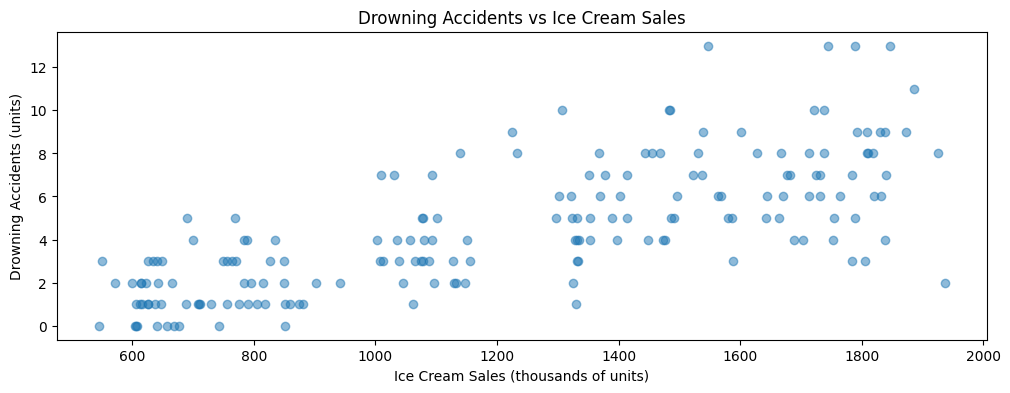

In [5]:
# Scatter plot of ice cream sales vs temperature, creams sales vs temperature, and drowning accidents vs temperature
plt.figure(figsize=(12, 4))

plt.scatter(monthly_df['ice_cream_sales'], monthly_df['drowning_accidents'], alpha=0.5)
plt.xlabel('Ice Cream Sales (thousands of units)')
plt.ylabel('Drowning Accidents (units)')
plt.title('Drowning Accidents vs Ice Cream Sales')

plt.show()

Podría pensar que el modelo causal es:

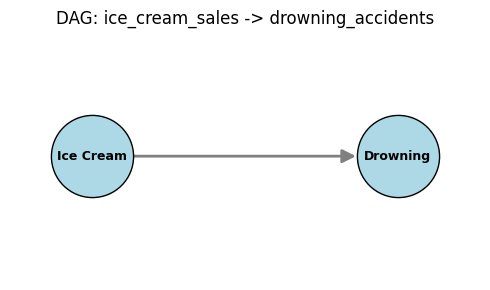

In [6]:
# Plot a causal model of the relationship between ice cream sales and drowning accidents: ice_cream_sales -> drowning_accidents
# Use GML to define the relationship between ice cream sales and drowning accidents
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()
G.add_edge("ice_cream_sales", "drowning_accidents")

# Posiciones manuales (para 2 nodos)
pos = {
    "ice_cream_sales": (0, 0),
    "drowning_accidents": (2, 0)
}

plt.figure(figsize=(5,3))

# Dibujar nodos
nx.draw_networkx_nodes(
    G, pos,
    node_color='lightblue',
    node_size=3500,       # Aumenta el tamaño de los nodos
    linewidths=1,
    edgecolors='black'
)

# Dibujar flechas
nx.draw_networkx_edges(
    G, pos,
    arrows = True,
    arrowstyle='-|>',
    arrowsize=20,
    width=2,
    edge_color='gray',
    connectionstyle='arc3,rad=0.0',
    min_source_margin=30,     
    min_target_margin=30
)

# Dibujar etiquetas
nx.draw_networkx_labels(
    G, pos,
    font_size=9,         # Reduce el tamaño de la fuente
    font_weight='bold',
    # Opcional: cambiar texto de las etiquetas para que sea más corto
    labels={
        "ice_cream_sales": "Ice Cream",
        "drowning_accidents": "Drowning"
    }
    # Si prefieres mantener los nombres largos, simplemente quita el argumento labels
)
# nx.draw_networkx_labels(
#     G, pos,
#     font_size=9,
#     font_weight='bold',
#     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none")
# )

# Ajustar márgenes
plt.margins(x=0.2, y=0.2)
plt.axis('off')
plt.title("DAG: ice_cream_sales -> drowning_accidents")
plt.tight_layout()
plt.show()



Basándonos en ese modelo ajustaríamos este modelo:

In [7]:
# Fit an OLS model drowning_accidents ~ ice_cream_sales
import statsmodels.api as sm

X = monthly_data['ice_cream_sales']
X = sm.add_constant(X)
y = monthly_data['drowning_accidents']

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     drowning_accidents   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     215.8
Date:                Wed, 19 Mar 2025   Prob (F-statistic):           1.63e-32
Time:                        10:32:15   Log-Likelihood:                -381.86
No. Observations:                 180   AIC:                             767.7
Df Residuals:                     178   BIC:                             774.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.8834      0.459     -4.100      0.000      -2.790      -0.977
ice_cream_sales     0.0053      0.000     14.691      0.000       0.005       0.006
==============================================================================
Omnibus:                       11.156   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               13.119
Skew:                           0.462   Prob(JB):                      0.00142
Kurtosis:                       3.947   Cond. No.                     3.90e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.9e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Vemos que los helados tienen un efecto causal significativo.

Pero sabemos que eso no tiene sentido. No hace falta pensar mucho para pensar que hay un *confounder*, una variable que afecta a ambas variables. En este caso, la temperatura. La temperatura afecta a la venta de helados y a los ahogamientos. El modelo causal ahora sería:

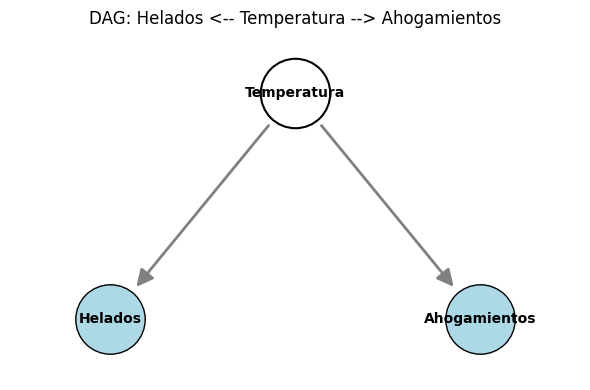

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

# Creamos un DAG
G = nx.DiGraph()

# Agregamos nodos (Temperatura, Helados, Ahogamientos)
G.add_node("Temperatura")
G.add_node("Helados")
G.add_node("Ahogamientos")

# Agregamos las flechas
G.add_edge("Temperatura", "Helados")
G.add_edge("Temperatura", "Ahogamientos")

# Definimos posiciones (para 3 nodos)
pos = {
    "Temperatura": (1, 1),
    "Helados": (0, 0),
    "Ahogamientos": (2, 0)
}

plt.figure(figsize=(6, 4))

# Nodos 'visibles' (Helados y Ahogamientos)
nx.draw_networkx_nodes(
    G,
    pos,
    nodelist=["Helados", "Ahogamientos"],
    node_color='lightblue',
    node_size=2500,
    edgecolors='black'
)

# Nodo 'oculto' (Temperatura) con estilo diferente
nx.draw_networkx_nodes(
    G,
    pos,
    nodelist=["Temperatura"],
    node_color='white',
    node_size=2500,
    edgecolors='black',
    linewidths=1.5,
    # node_shape='s',           # Cambia la forma (cuadrado)
    # No existe style='dashed' para nodos, pero podemos simularlo con edge dashes:
    # (Se necesitan funciones avanzadas, ver "patches" en matplotlib. Como alternativa, 
    # simplemente se deja color blanco o se cambia la forma para indicar que es "oculto".)
)

# Dibujamos flechas (aristas)
nx.draw_networkx_edges(
    G,
    pos,
    arrows=True,
    arrowstyle='-|>',
    arrowsize=25,
    width=2,
    edge_color='gray',
    min_source_margin=30,     
    min_target_margin=30
)

# Etiquetas
nx.draw_networkx_labels(
    G,
    pos,
    font_size=10,
    font_weight='bold'
)

plt.title("DAG: Helados <-- Temperatura --> Ahogamientos")

plt.margins(x=0.2, y=0.2)  # Agrega un margen extra alrededor
plt.axis('off')
plt.tight_layout()
plt.show()


Al añadir la temperatura al modelo, el efecto de los helados deja de ser significativo:

In [10]:
X = monthly_df[['ice_cream_sales', 'temperature']]
X = sm.add_constant(X)
y = monthly_df['drowning_accidents']

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     drowning_accidents   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     108.1
Date:                Wed, 19 Mar 2025   Prob (F-statistic):           2.07e-31
Time:                        10:33:36   Log-Likelihood:                -381.47
No. Observations:                 180   AIC:                             768.9
Df Residuals:                     177   BIC:                             778.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.8748      1.250     -0.700      0.485      -3.341       1.591
ice_cream_sales     0.0020      0.004      0.528      0.598      -0.005       0.009
temperature         0.1971      0.227      0.868      0.387      -0.251       0.645
==============================================================================
Omnibus:                        9.408   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               10.633
Skew:                           0.415   Prob(JB):                      0.00491
Kurtosis:                       3.854   Cond. No.                     1.07e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.07e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

El verdadero modelo causal, el que nos permite medir el efecto de la verdadera causa (la temperatura) sobre los ahogamientos, es el siguiente:

In [11]:
X = monthly_df[['temperature']]
X = sm.add_constant(X)
y = monthly_df['drowning_accidents']

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     drowning_accidents   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     216.9
Date:                Wed, 19 Mar 2025   Prob (F-statistic):           1.28e-32
Time:                        10:33:44   Log-Likelihood:                -381.62
No. Observations:                 180   AIC:                             767.2
Df Residuals:                     178   BIC:                             773.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.2423      0.355     -0.682      0.496      -0.943       0.458
temperature     0.3164      0.021     14.726      0.000       0.274       0.359
==============================================================================
Omnibus:                        8.585   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                9.497
Skew:                           0.392   Prob(JB):                      0.00867
Kurtosis:                       3.807   Cond. No.                         38.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Viendo como se "fabricaron" los datos, el coeficiente de `temperature` es el esperado y refleja el verdadero efecto causal.

# Impresiones, clicks y ventas: un ejemplo de *chain*

Generemos unos datos *mock* para ilustrar el concepto de *chain*:

$$
\text{impressions} \sim U(1000, 5000) \\
\text{clicks} \sim 0.1 \times \text{impressions} + N(0,100) \\
\text{sales} \sim 0.05 \times \text{clicks} + N(0,10) = 0.05 \times 0.1 \times \text{impressions} + 0.05 \times N(0, 100) + N(0,10)
$$

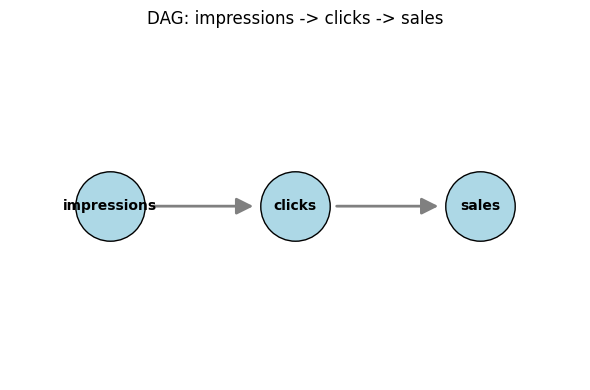

In [12]:
# Plot this DAG: impressions -> clicks -> sales
G = nx.DiGraph()
G.add_edge("impressions", "clicks")
G.add_edge("clicks", "sales")

pos = {
    "impressions": (0, 1),
    "clicks": (1, 1),
    "sales": (2, 1)
}

plt.figure(figsize=(6, 4))

nx.draw_networkx_nodes(
    G, pos,
    node_color='lightblue',
    node_size=2500,
    edgecolors='black'
)

nx.draw_networkx_edges(
    G, pos,
    arrows=True,
    arrowstyle='-|>',
    arrowsize=25,
    width=2,
    edge_color='gray',
    min_source_margin=30,     
    min_target_margin=30
)

nx.draw_networkx_labels(
    G, pos,
    font_size=10,
    font_weight='bold'
)

plt.title("DAG: impressions -> clicks -> sales")
plt.margins(x=0.2, y=0.2)
plt.axis('off')
plt.tight_layout()
plt.show()

In [13]:
# Genera un pd.Dataframe vacío con un índice de fechas semanales desde 2020-01-01 hasta 2024-12-31
weekly_dates = pd.date_range(start='2020-01-01', end='2024-12-31', freq='W')
weekly_df = pd.DataFrame(index=weekly_dates)

# La columna impresiones tendrá valores aleatorios entre 1000 y 5000
import numpy as np
np.random.seed(0)
weekly_df['impressions'] = np.random.randint(1000, 5000, len(weekly_df))

# La columna clics será 0.1 * impresiones + un ruido normal con media 0 y desviación estándar de 100
weekly_df['clicks'] = 0.1 * weekly_df['impressions'] + np.random.normal(0, 100, len(weekly_df))
# Redondear a números enteros
weekly_df['clicks'] = weekly_df['clicks'].round().astype(int)

# La columna sales será 0.05 * impresiones + un ruido normal con media 0 y desviación estándar de 10
weekly_df['sales'] = 0.05 * weekly_df['clicks'] + np.random.normal(0, 10, len(weekly_df))
# Redondear a números enteros
weekly_df['sales'] = weekly_df['sales'].round().astype(int)

weekly_df

,impressions,clicks,sales
2020-01-05,3732,434,17
2020-01-12,3607,186,-1
2020-01-19,2653,418,19
2020-01-26,4264,613,15
2020-02-02,1835,313,30
...,...,...,...
2024-12-01,3089,392,23
2024-12-08,3322,437,25
2024-12-15,4624,386,8
2024-12-22,4510,442,26


In [14]:
weekly_df.corr()

,impressions,clicks,sales
impressions,1.000000,0.733379,0.427921
clicks,0.733379,1.000000,0.584154
sales,0.427921,0.584154,1.000000


In [15]:
# Ajusta un modelo OLS de ventas ~ impresiones + clics
X = weekly_df[['impressions', 'clicks']]
X = sm.add_constant(X)
y = weekly_df['sales']  

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     66.82
Date:                Wed, 19 Mar 2025   Prob (F-statistic):           4.13e-24
Time:                        10:34:38   Log-Likelihood:                -976.24
No. Observations:                 261   AIC:                             1958.
Df Residuals:                     258   BIC:                             1969.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.3458      1.902     -0.708      0.480      -5.090       2.399
impressions -1.234e-05      0.001     -0.014      0.989      -0.002       0.002
clicks          0.0506      0.006      7.869      0.000       0.038       0.063
==============================================================================
Omnibus:                        2.201   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.333   Jarque-Bera (JB):                1.799
Skew:                          -0.048   Prob(JB):                        0.407
Kurtosis:                       2.605   Cond. No.                     9.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

`clicks` entra con su coeficiente causal (directo = total) pero `impressions` no entra. 

In [16]:
X = weekly_df[['clicks']]
X = sm.add_constant(X)
y = weekly_df['sales']  

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     134.2
Date:                Wed, 19 Mar 2025   Prob (F-statistic):           2.82e-25
Time:                        10:35:21   Log-Likelihood:                -976.24
No. Observations:                 261   AIC:                             1956.
Df Residuals:                     259   BIC:                             1964.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3635      1.424     -0.957      0.339      -4.168       1.441
clicks         0.0506      0.004     11.583      0.000       0.042       0.059
==============================================================================
Omnibus:                        2.204   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.332   Jarque-Bera (JB):                1.799
Skew:                          -0.048   Prob(JB):                        0.407
Kurtosis:                       2.605   Cond. No.                         734.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Mismo coeficiente para `clicks` que en el modelo anterior, es su efecto causal total = directo

In [17]:
X = weekly_df[['impressions']]
X = sm.add_constant(X)
y = weekly_df['sales']  

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     58.06
Date:                Wed, 19 Mar 2025   Prob (F-statistic):           4.80e-13
Time:                        10:35:33   Log-Likelihood:                -1004.3
No. Observations:                 261   AIC:                             2013.
Df Residuals:                     259   BIC:                             2020.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.7607      2.113     -0.833      0.405      -5.921       2.399
impressions     0.0050      0.001      7.620      0.000       0.004       0.006
==============================================================================
Omnibus:                        0.107   Durbin-Watson:                   2.088
Prob(Omnibus):                  0.948   Jarque-Bera (JB):                0.237
Skew:                           0.004   Prob(JB):                        0.888
Kurtosis:                       2.853   Cond. No.                     9.58e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.58e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

`impressions` entra con un coeficiente $0.05 \times 0.1 = 0.005$ (se multiplican los coeficientes de la cadena) que es su efecto causal total = indirecto


# ¿Más precio, mejor calidad?: un ejemplo de *collider*

Algunos smartphones de la marca Xiaomi suelen tener especificaciones y acabados de buena calidad (pantallas, cámaras, materiales), pero a un precio notablemente inferior al de marcas como Apple o Samsung. Esto rompe la idea de que “cuanto más caro, mejor calidad”: hay casos en los que la calidad es muy competitiva sin que el precio sea necesariamente alto.

En este caso un modelo causal sería:

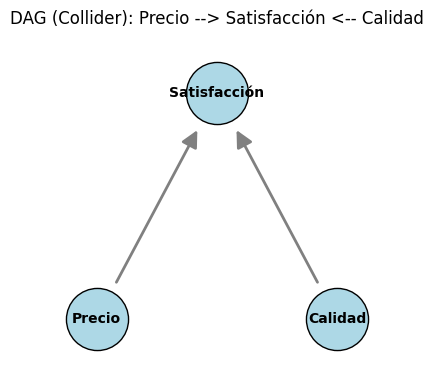

In [22]:
import networkx as nx

import matplotlib.pyplot as plt

# Crear un nuevo grafo
G = nx.DiGraph()

# Agregar nodos
G.add_node("Precio")
G.add_node("Satisfacción")
G.add_node("Calidad")

# Agregar aristas
G.add_edge("Precio", "Satisfacción")
G.add_edge("Calidad", "Satisfacción")

# Posiciones manuales (3 nodos en forma de "V")
pos = {
    "Precio": (0, 0),
    "Satisfacción": (1, 1),
    "Calidad": (2, 0)
}

plt.figure(figsize=(4,4))

# Dibujar nodos
nx.draw_networkx_nodes(G, pos,
    node_color='lightblue',
    node_size=2000,
    edgecolors='black'
)

# Dibujar flechas
nx.draw_networkx_edges(G, pos,
    arrows=True,
    arrowstyle='-|>',
    arrowsize=25,
    width=2,
    edge_color='gray',
    min_source_margin=30,     
    min_target_margin=30
)

# Etiquetas
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

plt.axis('off')
plt.title("DAG (Collider): Precio --> Satisfacción <-- Calidad")
plt.margins(x=0.2, y=0.2)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd

# Semilla para reproducibilidad
np.random.seed(42)

# Tamaño de la muestra
N = 1000

# 1) Generar Price y Quality independientes (aprox.)
price = np.random.normal(loc=100, scale=10, size=N)  # Ej: precios en euros
quality = np.random.normal(loc=5,   scale=1,  size=N)  # Ej: "calidad" en [1..10] (aprox.)

# 2) Definir Satisfaction como función de Price y Quality
#    + algo de ruido
#    - supongamos que a mayor precio, menor satisfacción (por coste)
#    - a mayor calidad, mayor satisfacción
satisfaction = 20 * quality - 0.5 * price + np.random.normal(loc=0, scale=2, size=N)

# Combinar en un DataFrame
df = pd.DataFrame({
    "Price": price,
    "Quality": quality,
    "Satisfaction": satisfaction
})

print(df.head(10))


        Price   Quality  Satisfaction
0  104.967142  6.399355     74.153181
1   98.617357  5.924634     68.894958
2  106.476885  5.059630     46.369325
3  115.230299  4.353063     28.830192
4   97.658466  5.698223     61.348004
5   97.658630  5.393485     59.466980
6  115.792128  5.895193     60.010211
7  107.674347  5.635172     57.232085
8   95.305256  6.049553     74.656918
9  105.425600  4.464765     38.457636


In [ ]:
df.corr()

,Price,Quality,Satisfaction
Price,1.000000,-0.040400,-0.272121
Quality,-0.040400,1.000000,0.967817
Satisfaction,-0.272121,0.967817,1.000000


Supongamos que queremos predecir el precio a partir de la calidad y la satisfacción. Si ajustamos el modelo:

In [ ]:
# Ajusta un modelo OLS de precio ~ satisfacción + calidad
X = df[['Satisfaction', 'Quality']]
X = sm.add_constant(X)
y = df['Price']

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     3038.
Date:                Tue, 04 Mar 2025   Prob (F-statistic):               0.00
Time:                        16:37:12   Log-Likelihood:                -2720.4
No. Observations:                1000   AIC:                             5447.
Df Residuals:                     997   BIC:                             5462.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           13.8729      1.285     10.798      0.000      11.352      16.394
Satisfaction    -1.7327      0.022    -77.872      0.000      -1.776      -1.689
Quality         34.5631      0.464     74.511      0.000      33.653      35.473
==============================================================================
Omnibus:                        0.943   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.624   Jarque-Bera (JB):                0.895
Skew:                           0.073   Prob(JB):                        0.639
Kurtosis:                       3.016   Cond. No.                         651.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Parece que la calidad tiene efecto causal sobre el precio pero sabemos que no es verdad. El modelo correcto es:

In [ ]:
# Ajusta un modelo OLS de precio ~ satisfacción + calidad
X = df[['Quality']]
X = sm.add_constant(X)
y = df['Price']

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.632
Date:                Tue, 04 Mar 2025   Prob (F-statistic):              0.202
Time:                        16:44:17   Log-Likelihood:                -3699.2
No. Observations:                1000   AIC:                             7402.
Df Residuals:                     998   BIC:                             7412.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        102.2045      1.605     63.693      0.000      99.056     105.353
Quality       -0.3966      0.311     -1.277      0.202      -1.006       0.213
==============================================================================
Omnibus:                        2.826   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.243   Jarque-Bera (JB):                2.698
Skew:                           0.122   Prob(JB):                        0.260
Kurtosis:                       3.075   Cond. No.                         27.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Vemos que la calidad no es significativa causalmente.

# Resumen

| Tipo de relación | DAG     | Comentarios | Si condiciono en Z... | Si *NO* condiciono en Z... |
|-------------------|---------|-------------|----------------------|----------------------------|
| *Fork*            | X <- Z -> Y | X e Y están correlacionadas porque comparten una causa común, Z. Pero no hay relación causal entre X e Y, la correlación es espuria.| X e Y dejan de estar correlacionadas porque se cierra el flujo de información entre X e Y a través de Z. Esto permite estimar el nulo efecto causal entre X e Y | Creeré que hay un efecto causal entre X e Y cuando no lo hay |
| *Chain*           | X -> Z -> Y | X e Y están correlacionadas porque X afecta a Z y Z afecta a Y. X es causa de Y. | X e Y dejan de estar correlacionadas porque se cierra el flujo de información entre X e Y a través de Z. Esto impide estimar el efecto causal (indirecto = total) entre X e Y | Podré estimar el efecto causal (indirecto = total) entre X e Y |
| *Collider*        | X -> Z <- Y | X e Y no están correlacionadas. No hay relación causal entre X e Y. | Se induce una correlación espuria entre X e Y porque se abre el flujo de información entre X e Y. Creeré que hay un efecto causal entre X e Y cuando no lo hay |  Permite estimar el nulo efecto causal entre X e Y |

Todo DAG más complicado se compone de estos 3 elementos básicos. Pero ya no es "tan fácil" identificar los efectos causales. Debemos acudir a algoritmos (estimandos) como:

+ *Backdoor criterion*
+ *Frontdoor criterion*
+ *Instrumental variables*

y, si ninguno de estos 3 es aplicable, tendremos que aplicar *do-calculus*.

La buena noticia es que existen librearías de Python que implementan estos algoritmos. Por ejemplo, `dowhy` o `econml`.